## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [30]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [31]:
train, test = keras.datasets.cifar10.load_data()

In [32]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [33]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [34]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [19]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [20]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.8]
reduce_lr_patient = [2,8]

In [24]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print(f"Numbers of exp: {i}, reduce_factor: {reduce_factor}, reduce_patient: {reduce_patient}, optimizer:{optim}")
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor,
                                  min_lr = 1e-12,
                                  monitor = 'val_loss',
                                  patience = reduce_patient,
                                  verbose = 1
                                 )
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.2, reduce_patient: 2, optimizer:<keras.optimizers.SGD object at 0x7f724b450978>
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
________

50000/50000 [==============================] - 3s 50us/step - loss: 1.9860 - accuracy: 0.3208 - val_loss: 1.9678 - val_accuracy: 0.3166
Epoch 11/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.9608 - accuracy: 0.3270 - val_loss: 1.9606 - val_accuracy: 0.3209
Epoch 12/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.9378 - accuracy: 0.3348 - val_loss: 1.9493 - val_accuracy: 0.3255
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.9187 - accuracy: 0.3394 - val_loss: 1.9420 - val_accuracy: 0.3284
Epoch 14/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.9008 - accuracy: 0.3442 - val_loss: 1.9323 - val_accuracy: 0.3319
Epoch 15/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.8833 - accuracy: 0.3501 - val_loss: 1.9214 - val_accuracy: 0.3338
Epoch 16/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.8672 - accuracy: 0.3557 - val_loss: 1.9114

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 72us/step - loss: 2.9186 - accuracy: 0.1248 - val_loss: 2.3161 - val_accuracy: 0.1316
Epoch 2/25
50000/50000 [==============================] - 2s 47us/step - loss: 2.5068 - accuracy: 0.1975 - val_loss: 2.2535 - val_accuracy: 0.1783
Epoch 3/25
50000/50000 [==============================] - 2s 47us/step - loss: 2.3335 - accuracy: 0.2329 - val_loss: 2.1899 - val_accuracy: 0.2074
Epoch 4/25
50000/50000 [==============================] - 3s 51us/step - loss: 2.2327 - accuracy: 0.2569 - val_loss: 2.1287 - val_accuracy: 0.2355
Epoch 5/25
50000/50000 [==============================] - 2s 49us/step - loss: 2.1611 - accuracy: 0.2750 - val_loss: 2.0715 - val_accuracy: 0.2580
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.1075 - accuracy: 0.2883 - val_loss: 2.0258 - val_accuracy: 0.2781
Epoch 7/25
50000/50000 [==============================] - 2s 47us/st

50000/50000 [==============================] - 3s 51us/step - loss: 3.0249 - accuracy: 0.1007 - val_loss: 3.0326 - val_accuracy: 0.1018
Epoch 21/25
50000/50000 [==============================] - 3s 53us/step - loss: 3.0246 - accuracy: 0.1010 - val_loss: 3.0336 - val_accuracy: 0.1019
Epoch 22/25
50000/50000 [==============================] - 3s 53us/step - loss: 3.0242 - accuracy: 0.1011 - val_loss: 3.0341 - val_accuracy: 0.1018
Epoch 23/25
50000/50000 [==============================] - 3s 53us/step - loss: 3.0249 - accuracy: 0.1002 - val_loss: 3.0347 - val_accuracy: 0.1018
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 3.0260 - accuracy: 0.1007 - val_loss: 3.0352 - val_accuracy: 0.1018
Epoch 25/25
50000/50000 [==============================] - 3s 50us/step - loss: 3.0250 - accuracy: 0.1009 - val_loss: 3.0354 - val_accuracy: 0.1018
Numbers of exp: 5, reduce_factor: 0.2, reduce_patient: 8, optimizer:<keras.optimizers.Adam object at 0x7f724b450cf8>
Model: 

50000/50000 [==============================] - 2s 49us/step - loss: 3.2055 - accuracy: 0.0855 - val_loss: 2.5664 - val_accuracy: 0.0758
Epoch 5/25
50000/50000 [==============================] - 2s 50us/step - loss: 3.2049 - accuracy: 0.0852 - val_loss: 2.6445 - val_accuracy: 0.0757
Epoch 6/25
50000/50000 [==============================] - 3s 50us/step - loss: 3.2057 - accuracy: 0.0850 - val_loss: 2.7236 - val_accuracy: 0.0799
Epoch 7/25
50000/50000 [==============================] - 3s 50us/step - loss: 3.2058 - accuracy: 0.0853 - val_loss: 2.8011 - val_accuracy: 0.0820
Epoch 8/25
50000/50000 [==============================] - 2s 49us/step - loss: 3.2058 - accuracy: 0.0847 - val_loss: 2.8738 - val_accuracy: 0.0835
Epoch 9/25
50000/50000 [==============================] - 3s 51us/step - loss: 3.2052 - accuracy: 0.0856 - val_loss: 2.9385 - val_accuracy: 0.0858
Epoch 10/25
50000/50000 [==============================] - 3s 58us/step - loss: 3.2063 - accuracy: 0.0851 - val_loss: 2.9946 - va

Epoch 24/25
50000/50000 [==============================] - 2s 50us/step - loss: 3.0545 - accuracy: 0.1025 - val_loss: 3.0466 - val_accuracy: 0.1019
Epoch 25/25
50000/50000 [==============================] - 2s 49us/step - loss: 3.0541 - accuracy: 0.1010 - val_loss: 3.0468 - val_accuracy: 0.1019
Numbers of exp: 8, reduce_factor: 0.2, reduce_patient: 2, optimizer:<keras.optimizers.RMSprop object at 0x7f724b450d30>
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 25

50000/50000 [==============================] - 2s 47us/step - loss: 3.1808 - accuracy: 0.0786 - val_loss: 2.8009 - val_accuracy: 0.0825
Epoch 8/25
50000/50000 [==============================] - 2s 47us/step - loss: 3.1804 - accuracy: 0.0783 - val_loss: 2.8684 - val_accuracy: 0.0823
Epoch 9/25
50000/50000 [==============================] - 2s 48us/step - loss: 3.1801 - accuracy: 0.0776 - val_loss: 2.9289 - val_accuracy: 0.0813
Epoch 10/25
50000/50000 [==============================] - 2s 47us/step - loss: 3.1807 - accuracy: 0.0778 - val_loss: 2.9810 - val_accuracy: 0.0821
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 3.1808 - accuracy: 0.0777 - val_loss: 3.0247 - val_accuracy: 0.0806
Epoch 12/25
50000/50000 [==============================] - 2s 48us/step - loss: 3.1802 - accuracy: 0.0785 - val_loss: 3.0609 - val_accuracy: 0.0807
Epoch 13/25
50000/50000 [==============================] - 2s 47us/step - loss: 3.1793 - accuracy: 0.0788 - val_loss: 3.0892 -

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_82 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_84 (Batc (None, 256)               102

In [29]:
model.history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

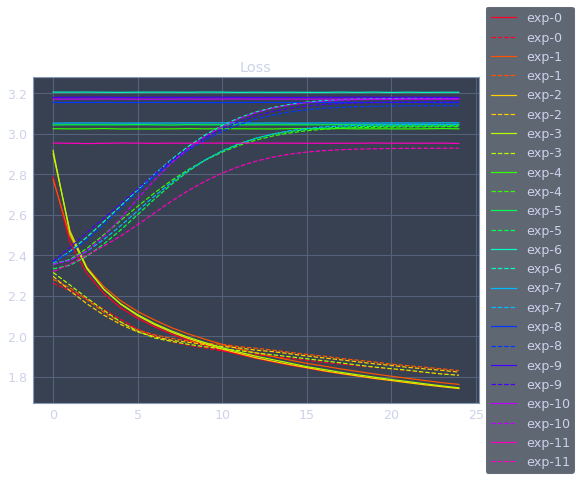

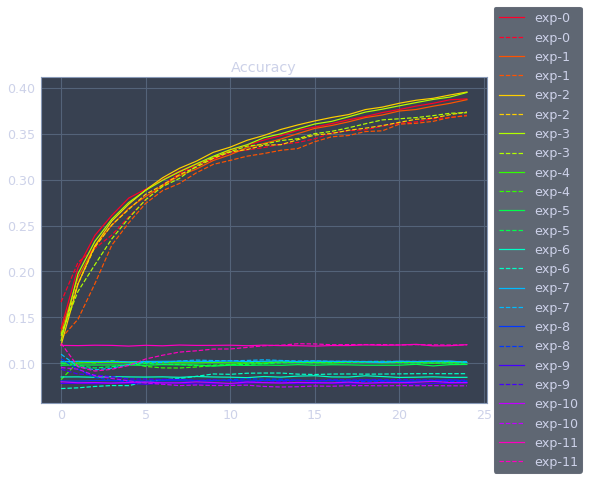

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [28]:
! jupyter nbconvert --to html Day_087HW.ipynb Day_087_CB_ReduceLR.ipynb

[NbConvertApp] Converting notebook Day_087HW.ipynb to html
[NbConvertApp] Writing 657059 bytes to Day_087HW.html
[NbConvertApp] Converting notebook Day_087_CB_ReduceLR.ipynb to html
[NbConvertApp] Writing 413717 bytes to Day_087_CB_ReduceLR.html
